# Bridging the gap between binary image (segmentation) and analysis


The primary goal of the Allen Cell Segmenter is to convert fluroscent images into binary images, i.e., the mask of the target structures (a.k.a segmentation). But, the binary images are not really meaningful (except, for example, visualization) until they are converted into statistically sound numbers. This jupyter notebook is to show some example ways to bridge such gap. 

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from aicsimageio import AICSImage
from aicssegmentation.cli.to_analysis import simple_builder, masked_builder
from itkwidgets import view

## Load the binary image generated by segmenter (i.e. structure segmentation result)

In [2]:
structure_seg_reader = AICSImage('../demo_data/TOMM20_pipeline_example_structure_segmentation.tiff')
structure_seg = structure_seg_reader.data[0,0,:,:,:]

## Method 1: `simply_builder`

#### Simply convert the binary image into individual analyzable objects

This is useful when you want to get some whole FOV meansurements

#### instuction:

`obj_simple = simple_builder(structure_seg)`

The output `obj_simple` is an image with the same size as input binary image. But, each individual objects are labeled as a unique integer value.

or

`obj_simple, obj_simple_df = simple_builder(structure_seg, return_dataframe=True)`

The output `obj_simple` is the same as above, but, a pre-built dataframe is return, ready for your analysis

In [ ]:
# only getting the label image
obj_simple = simple_builder(structure_seg)

In [ ]:
# get the number of objects
print(obj_simple.max())

In [ ]:
# calculat the volume of object 76
print(np.count_nonzero(obj_simple==76))

In [ ]:
# getting both the label image and the pre-built dataframe
obj_simple, obj_simple_df = simple_builder(structure_seg, return_dataframe=True)

In [ ]:
# calculate the volume of each object and report the average and standard diviation
obj_simple_df = obj_simple_df.assign(vol="")
for index, row in obj_simple_df.iterrows():
    obj_index = int(row['object_index'])
    vol = np.count_nonzero(obj_simple==obj_index)
    obj_simple_df.loc[index, 'vol'] = vol

In [ ]:
# do some statistics

# sum
print(obj_simple_df.vol.sum())

# average
print(obj_simple_df.vol.mean())

# standard deviation
print(obj_simple_df.vol.std())

# min
print(obj_simple_df.vol.min())

# max
print(obj_simple_df.vol.max())

## Method 2: `masked_builder`

#### Convert the binary image into individual ***groups*** of analyzable objects according to a mask label

**What is a mask label? Depending on the biological questions to study, the mask label may vary. It could be areas enclosed by each individual cell or each individual nucleus, or any way you want to partition the image into differnet regions. Then, all the pieces in one particular cell/nucleus/cutomized region in the structure segmentation will have the same group id.**


For example, this is useful when you want do per-cell measurements using cell segmentation as the mask label.

*Note: In this demo, we are using a cell segmentation generated by a deep learning based segmentation algorithm developed at the Allen Institute for Cell Science. We are working on the release of nucleus/cell segmentation algorithms. Stay tuned :) For your data, you may use your own cell/nucleus segmentation algorithm or you can do manual annotation in Fiji.*

#### instruction:

`obj_label, obj_df= masked_builder(structure_seg, cell_seg)`

The output `obj_label` is an image with the same size as input binary image. But, each individual objects are labeled as a unique integer value. `obj_df` is a dataframe with two-level indexing: "mask_id" and "obj_id". The "obj_id" corresponds to the unique integer values in `obj_label`. "mask_id" corresponds to each individual cell in the cell segmentaiton. The volume of each individual object is pre-calculated by default and returned together with the dataframe


In [3]:
cell_seg_reader = AICSImage('../demo_data/TOMM20_pipeline_example_cell_segmentation.tiff')
cell_seg = cell_seg_reader.data[0,0,:,:,:]

In [4]:
obj_label, obj_df = masked_builder(structure_seg, cell_seg)

In [6]:
obj_df.head()

vol
mask_id obj_id      
1       1       8286
        2        178
        3         84
        4          2
        5          2

In [14]:
# get the number of groups/cells

number_of_cells = len(np.unique(obj_df.index.get_level_values('mask_id')))


In [23]:
df_per_cell = []

for index, one_group in obj_df.groupby('mask_id'):
    cell_index = one_group.index.get_level_values('mask_id')[0]
    cell_vol = np.count_nonzero(cell_seg==cell_index)
    df_per_cell.append({
        "cell_index": cell_index,
        "cell_vol":cell_vol,
        "structure_vol_total":one_group['vol'].sum(),
        "structure_vol_average":one_group['vol'].mean(),
        "structure_vol_std":one_group['vol'].std(),
        "structure_number_of_pieces":one_group['vol'].count(),
    })
    
df_per_cell = pd.DataFrame(df_per_cell)

In [22]:
df_per_cell.head()

,cell_index,cell_vol,strucutre_number_of_pieces,strucutre_vol_average,strucutre_vol_std,strucutre_vol_total
0,1,124693,16,570.687500,2058.533417,9131
1,2,247804,16,543.250000,958.149084,8692
2,3,715281,97,465.371134,3214.156656,45141
3,4,723888,26,2073.115385,9035.658547,53901
4,5,205600,18,537.944444,1539.152650,9683


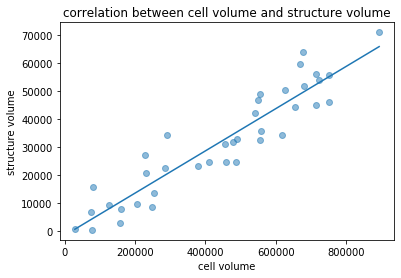

In [25]:
plt.scatter(df_per_cell.cell_vol, df_per_cell.structure_vol_total, marker='o', alpha=0.5)
plt.title('correlation between cell volume and structure volume')
plt.xlabel('cell volume')
plt.ylabel('structure volume')
plt.plot(np.unique(df_per_cell.cell_vol), np.poly1d(np.polyfit(df_per_cell.cell_vol, df_per_cell.structure_vol_total, 1))(np.unique(df_per_cell.cell_vol)))
plt.show()